In [1]:
#  This code is used just to create the skew-T plot of global, annual mean air temperature
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from metpy.plots import SkewT
import climlab

#plt.style.use('dark_background')

#  This code is used just to create the skew-T plot of global, annual mean air temperature
#ncep_url = "http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis.derived/"
ncep_url = "/Users/yuchiaol_ntuas/Desktop/ebooks/data/"
#time_coder = xr.coders.CFDatetimeCoder(use_cftime=True)
ncep_air = xr.open_dataset( ncep_url + "air.mon.1981-2010.ltm.nc", use_cftime=True)
#  Take global, annual average 
coslat = np.cos(np.deg2rad(ncep_air.lat))
weight = coslat / coslat.mean(dim='lat')
Tglobal = (ncep_air.air * weight).mean(dim=('lat','lon','time'))

print(Tglobal)

#  Resuable function to plot the temperature data on a Skew-T chart
def make_skewT():
    fig = plt.figure(figsize=(9, 9))
    skew = SkewT(fig, rotation=30)
    skew.plot(Tglobal.level, Tglobal, color='black', linestyle='-', linewidth=2, label='Observations')
    skew.ax.set_ylim(1050, 10)
    skew.ax.set_xlim(-90, 45)
    # Add the relevant special lines
    skew.plot_dry_adiabats(linewidth=0.5)
    skew.plot_moist_adiabats(linewidth=0.5)
    #skew.plot_mixing_lines()
    skew.ax.legend()
    skew.ax.set_xlabel('Temperature (degC)', fontsize=14)
    skew.ax.set_ylabel('Pressure (hPa)', fontsize=14)
    return skew

#  and a function to add extra profiles to this chart
def add_profile(skew, model, linestyle='-', color=None):
    line = skew.plot(model.lev, model.Tatm - climlab.constants.tempCtoK,
             label=model.name, linewidth=2)[0]
    skew.plot(1000, model.Ts - climlab.constants.tempCtoK, 'o', 
              markersize=8, color=line.get_color())
    skew.ax.legend()


<xarray.DataArray (level: 17)> Size: 68B
array([ 15.179084  ,  11.207003  ,   7.8383274 ,   0.21994135,
        -6.4483433 , -14.888848  , -25.570469  , -39.36969   ,
       -46.797905  , -53.652245  , -60.56356   , -67.006065  ,
       -65.53293   , -61.48664   , -55.853584  , -51.593952  ,
       -43.21999   ], dtype=float32)
Coordinates:
  * level    (level) float32 68B 1e+03 925.0 850.0 700.0 ... 50.0 30.0 20.0 10.0


In [2]:
# Get the water vapor data from CESM output
#cesm_data_path = "http://thredds.atmos.albany.edu:8080/thredds/dodsC/CESMA/"
cesm_data_path = "/Users/yuchiaol_ntuas/Desktop/ebooks/data/"
atm_control = xr.open_dataset(cesm_data_path + "cpl_1850_f19.cam.h0.nc")
# Take global, annual average of the specific humidity
weight_factor = atm_control.gw / atm_control.gw.mean(dim='lat')
Qglobal = (atm_control.Q * weight_factor).mean(dim=('lat','lon','time'))

#  Make a model on same vertical domain as the GCM
mystate = climlab.column_state(lev=Qglobal.lev, water_depth=2.5)
#  Build the radiation model -- just like we already did
rad = climlab.radiation.RRTMG(name='Radiation',
                              state=mystate, 
                              specific_humidity=Qglobal.values,
                              timestep = climlab.constants.seconds_per_day,
                              albedo = 0.25,  # surface albedo, tuned to give reasonable ASR for reference cloud-free model
                             )
#  Now create the convection model
conv = climlab.convection.ConvectiveAdjustment(name='Convection',
                                               state=mystate,
                                               adj_lapse_rate=6.5,
                                               timestep=rad.timestep,
                                              )
#  Here is where we build the model by coupling together the two components
rcm = climlab.couple([rad, conv], name='Radiative-Convective Model')

print(rcm)

print(rcm.subprocess['Radiation'].absorber_vmr['CO2'])

print(rcm.integrate_years(5))

print(rcm.ASR - rcm.OLR)


climlab Process of type <class 'climlab.process.time_dependent_process.TimeDependentProcess'>. 
State variables and domain shapes: 
  Ts: (1,) 
  Tatm: (26,) 
The subprocess tree: 
Radiative-Convective Model: <class 'climlab.process.time_dependent_process.TimeDependentProcess'>
   Radiation: <class 'climlab.radiation.rrtm.rrtmg.RRTMG'>
      SW: <class 'climlab.radiation.rrtm.rrtmg_sw.RRTMG_SW'>
      LW: <class 'climlab.radiation.rrtm.rrtmg_lw.RRTMG_LW'>
   Convection: <class 'climlab.convection.convadj.ConvectiveAdjustment'>

0.000348
Integrating for 1826 steps, 1826.2110000000002 days, or 5 years.


Total elapsed time is 4.999422301147019 years.
None
[-3.3651304e-11]


In [3]:
# Make an exact clone with same temperatures
rcm_2xCO2 = climlab.process_like(rcm)
rcm_2xCO2.name = 'Radiative-Convective Model (2xCO2 initial)'

#  Check to see that we indeed have the same CO2 amount
print(rcm_2xCO2.subprocess['Radiation'].absorber_vmr['CO2'])

#  Now double it!
rcm_2xCO2.subprocess['Radiation'].absorber_vmr['CO2'] *= 2

print(rcm_2xCO2.subprocess['Radiation'].absorber_vmr['CO2'])


0.000348
0.000696


In [4]:
rcm_2xCO2.compute_diagnostics()

print(rcm_2xCO2.ASR - rcm.ASR)

print(rcm_2xCO2.OLR - rcm.OLR)

DeltaR_instant = (rcm_2xCO2.ASR - rcm_2xCO2.OLR) - (rcm.ASR - rcm.OLR)

print(DeltaR_instant)


[0.06274162]
[-2.11458541]
[2.17732704]


In [5]:
# print out troposphere
print(rcm.lev[13:])

rcm_2xCO2_strat = climlab.process_like(rcm_2xCO2)
rcm_2xCO2_strat.name = 'Radiative-Convective Model (2xCO2 stratosphere-adjusted)'
for n in range(1000):
    rcm_2xCO2_strat.step_forward()
# hold tropospheric and surface temperatures fixed
    rcm_2xCO2_strat.Tatm[13:] = rcm.Tatm[13:]
    rcm_2xCO2_strat.Ts[:] = rcm.Ts[:]

DeltaR = (rcm_2xCO2_strat.ASR - rcm_2xCO2_strat.OLR) - (rcm.ASR - rcm.OLR)
print(DeltaR)


[226.513265 266.481155 313.501265 368.81798  433.895225 510.455255
 600.5242   696.79629  787.70206  867.16076  929.648875 970.55483
 992.5561  ]


[4.28837377]


In [6]:
OLRobserved = 238.5  # in W/m2
sigma = 5.67E-8  # S-B constant
Tsobserved = 288.  # global average surface temperature
tau = OLRobserved / sigma / Tsobserved**4  # solve for tuned value of transmissivity

lambda_0 = 4 * sigma * tau * Tsobserved**3

DeltaR = 4.  # Radiative forcing in W/m2
DeltaT0 = DeltaR / lambda_0
print( 'The Equilibrium Climate Sensitivity in the absence of feedback is {:.1f} K.'.format(DeltaT0))

The Equilibrium Climate Sensitivity in the absence of feedback is 1.2 K.


Integrating for 1826 steps, 1826.2110000000002 days, or 5 years.


Total elapsed time is 12.736753858124827 years.
[1.31308298e-11]
ECS with no feedback
[1.29984831]
[0.05080282]
[0.05080282]


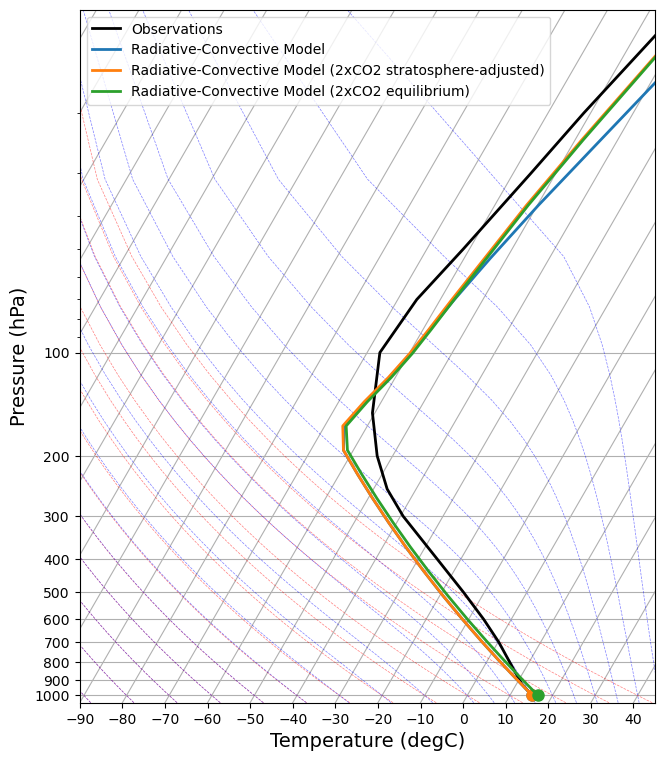

In [7]:
rcm_2xCO2_eq = climlab.process_like(rcm_2xCO2_strat)
rcm_2xCO2_eq.name = 'Radiative-Convective Model (2xCO2 equilibrium)'
rcm_2xCO2_eq.integrate_years(5)

print(rcm_2xCO2_eq.ASR - rcm_2xCO2_eq.OLR)

skew = make_skewT()
add_profile(skew, rcm)
add_profile(skew, rcm_2xCO2_strat)
add_profile(skew, rcm_2xCO2_eq)

ECS_nofeedback = rcm_2xCO2_eq.Ts - rcm.Ts
print('ECS with no feedback')
print(ECS_nofeedback)

print(rcm_2xCO2_eq.OLR - rcm.OLR)
print(rcm_2xCO2_eq.ASR - rcm.ASR)

